# ML. Ejemplo Modelo Lineal y Regularización

Los datos de este ejercicio provienen de un estudio realizado por Stamey et al. (1989) y es presentado en el capítulo 3 del libro guía "The Elements of Statistical Learning". Stamey et alexaminaron la correlación entre el nivel de antígeno prostático específico (lpsa) y varias medidas clínicas en hombres que estaban a punto de someterse a una prostatectomía radical. Las variables son: volumen de cáncer logarítmico (lcavol), peso prostático logarítmico (lweight), edad, logaritmo de la cantidad de hiperplasia prostática benigna (lbph), invasión de vesículas seminales (svi), logaritmo de la penetración capsular (lcp), puntuación de Gleason (gleason) y porcentaje de puntuaciones de Gleason de 4 o 5 (pgg45).




*Debe formar equipos de entre 2 y 4 personas para abordar las siguientes preguntas de modo consensuado. Designar un secretario que entrega el código y un vocero que expone en caso de ser interpelado.*



1.   ¿Es posible aprender a predecir satisfactoriamente la respuesta (lpsa) en función de los predictores disponibles?
2.   Si asumimos que el modelo lineal es correcto, ¿Qué variables están más relacionadas con la variable respuesta (lpsa)?



<table align='left'>
<tr>
<td><img src='https://assets.roche.com/f/173873/1920x1440/a7d6ecfcda/oncologie-cancer-prostate.jpg/m/768x0/filters:format(webp):quality(90)/' width='650'/>
</tr>
</table>


# Basic Imports

In [30]:
import pandas as pd
import numpy as np
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
from sklearn.utils import shuffle


import warnings; warnings.filterwarnings("ignore")
plt.rcParams.update({'font.size': 8})
plt.rc('xtick',labelsize=8)
plt.rc('ytick',labelsize=8)
plt.rc('axes', labelsize=8)
plt.rc('legend',fontsize=10)
plt.rc('axes',titlesize=10)


# Data

In [1]:
!wget http://www.inf.utfsm.cl/~jnancu/ProstateCancer.csv

--2024-09-12 18:58:35--  http://www.inf.utfsm.cl/~jnancu/ProstateCancer.csv
Resolving www.inf.utfsm.cl (www.inf.utfsm.cl)... 200.1.19.11, 2800:270:c::11
Connecting to www.inf.utfsm.cl (www.inf.utfsm.cl)|200.1.19.11|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.inf.utfsm.cl/~jnancu/ProstateCancer.csv [following]
--2024-09-12 18:58:35--  https://www.inf.utfsm.cl/~jnancu/ProstateCancer.csv
Connecting to www.inf.utfsm.cl (www.inf.utfsm.cl)|200.1.19.11|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7129 (7.0K) [application/octet-stream]
Saving to: ‘ProstateCancer.csv’

ProstateCancer.csv  100%[===================>]   6.96K  --.-KB/s    in 0s      

2024-09-12 18:58:37 (172 MB/s) - ‘ProstateCancer.csv’ saved [7129/7129]



In [56]:
data_raw = pd.read_table('ProstateCancer.csv', sep='\s+')

In [84]:
columns_x = data_raw.columns.tolist()
columns_x.remove("train")
columns_x.remove("lpsa")
columns_y = ['lpsa']
print(columns_x,columns_y)

['lcavol', 'lweight', 'age', 'lbph', 'svi', 'lcp', 'gleason', 'pgg45'] ['lpsa']


In [83]:
print(data_raw.head(5))

     lcavol   lweight  age      lbph  svi       lcp  gleason  pgg45      lpsa  \
1 -0.579818  2.769459   50 -1.386294    0 -1.386294        6      0 -0.430783   
2 -0.994252  3.319626   58 -1.386294    0 -1.386294        6      0 -0.162519   
3 -0.510826  2.691243   74 -1.386294    0 -1.386294        7     20 -0.162519   
4 -1.203973  3.282789   58 -1.386294    0 -1.386294        6      0 -0.162519   
5  0.751416  3.432373   62 -1.386294    0 -1.386294        6      0  0.371564   

  train  
1     T  
2     T  
3     T  
4     T  
5     T  


Variables:

- **lcavol**: Logaritmo del volumen de material canceroso, medido en mililitros (cc). Este volumen se estimó a partir de imágenes digitalizadas haciendo calculando el área ocupada y multiplicando por un grosor estándar para obtener un volumen.
- **lweight**: Logaritmo del peso de la próstata, medido en gramos.
- **age**: La edad del paciente, en años.
- **lbph**: Logaritmo de la cantidad de hiperplasia prostática benigna (BPH), un agrandamiento no canceroso de la glándula prostática, como un área en una imagen digitalizada y reportada en cm².
- **svi**: Invasión de las vesículas seminales, un indicador binario que indica si las células cancerosas de la próstata han invadido la vesícula seminal (1) o no (0).
- **lcp**: Logaritmo de la penetración capsular, que representa el nivel de extensión del cáncer en la cápsula (el tejido fibroso que actúa como revestimiento externo de la glándula prostática), medido como la extensión lineal de la penetración, en cm.
- **gleason**: Puntaje de Gleason, una medida del grado de agresividad del tumor. El sistema de clasificación de Gleason asigna una calificación (1–5) a cada una de las dos áreas más grandes de cáncer en las muestras de tejido, donde 1 es el menos agresivo y 5 el más agresivo; las dos calificaciones se suman para producir el puntaje de Gleason.
- **pgg45**: Porcentaje de puntuaciones de Gleason que son 4 o 5.
- **lpsa**: Logaritmo del antígeno prostático específico (PSA), una concentración medida en ng/mL.

# Basic Exploratory

In [105]:
ORIG=False
if ORIG:
  data = data_raw
else:
  data = X_train
  data['lpsa'] = y_train

In [106]:
data.columns

Index(['lcavol', 'lweight', 'age', 'lbph', 'svi', 'lcp', 'pgg45', 'gleason_6',
       'gleason_7', 'gleason_8', 'gleason_9', 'lpsa'],
      dtype='object')

In [107]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
data.describe()

,lcavol,lweight,age,lbph,svi,lcp,pgg45,gleason_6,gleason_7,gleason_8,gleason_9,lpsa
count,67.00,67.00,67.00,67.00,67.00,67.00,67.00,67.00,67.00,67.00,67.00,67.00
mean,0.00,0.00,-0.00,0.00,0.00,-0.00,-0.00,0.37,0.57,0.01,0.04,0.00
std,1.01,1.01,1.01,1.01,1.01,1.01,1.01,0.49,0.50,0.12,0.21,1.01
min,-2.16,-2.65,-3.19,-1.00,-0.54,-0.84,-0.90,0.00,0.00,0.00,0.00,-2.41
25%,-0.67,-0.63,-0.50,-1.00,-0.54,-0.84,-0.90,0.00,0.00,0.00,0.00,-0.65
50%,0.13,-0.06,0.03,-0.08,-0.54,-0.42,-0.39,0.00,1.00,0.00,0.00,0.10
75%,0.84,0.54,0.57,1.02,-0.54,0.87,0.82,1.00,1.00,0.00,0.00,0.76
max,2.03,2.44,1.91,1.55,1.86,2.07,2.54,1.00,1.00,1.00,1.00,2.52


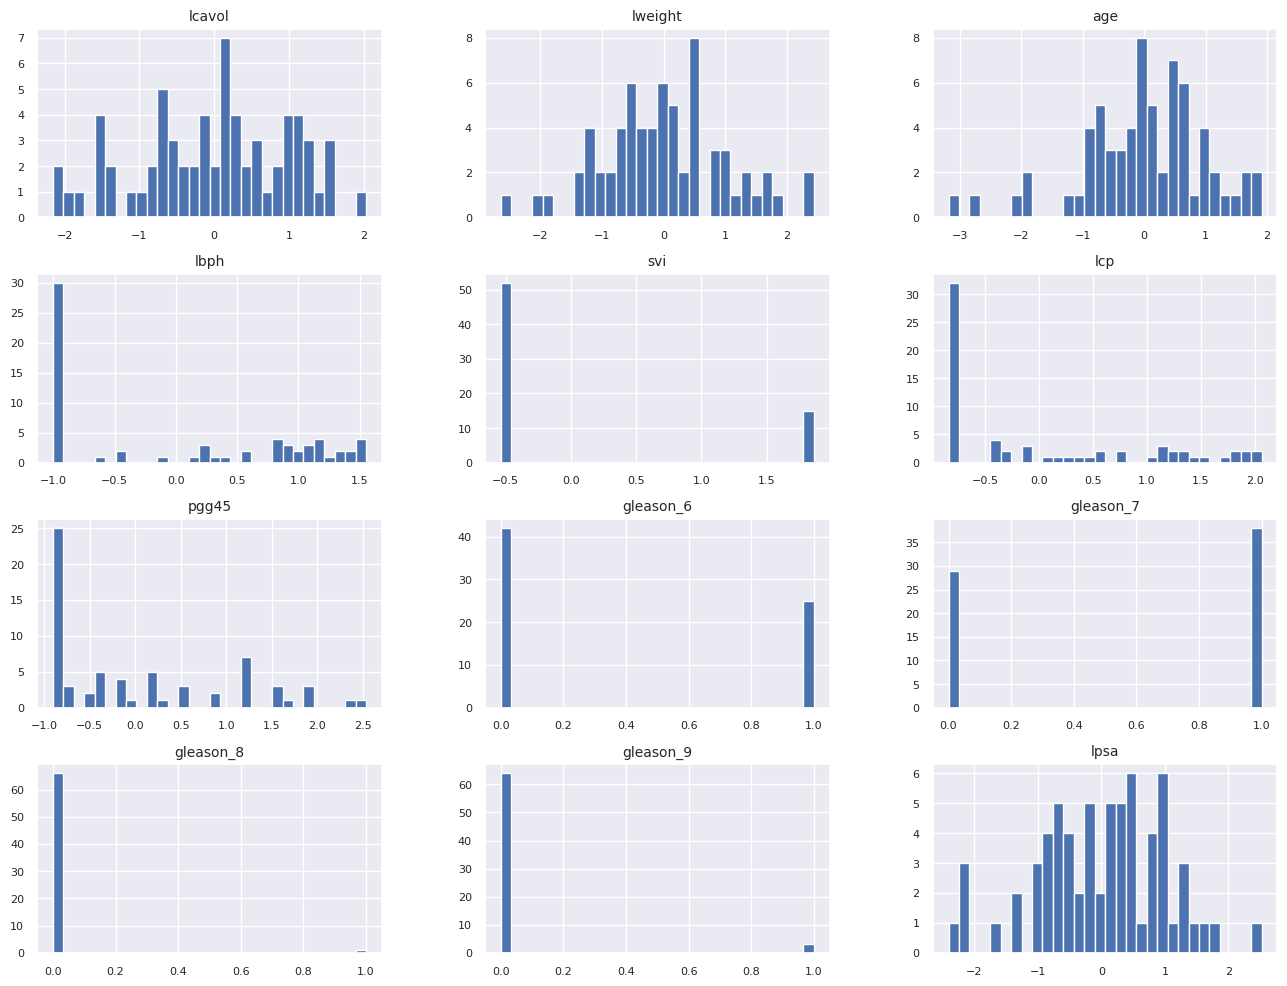

In [110]:
f = data.hist(bins=30, figsize=(16, 12))

Observaciones:

*   svi es binaria
*   gleason parece discreta


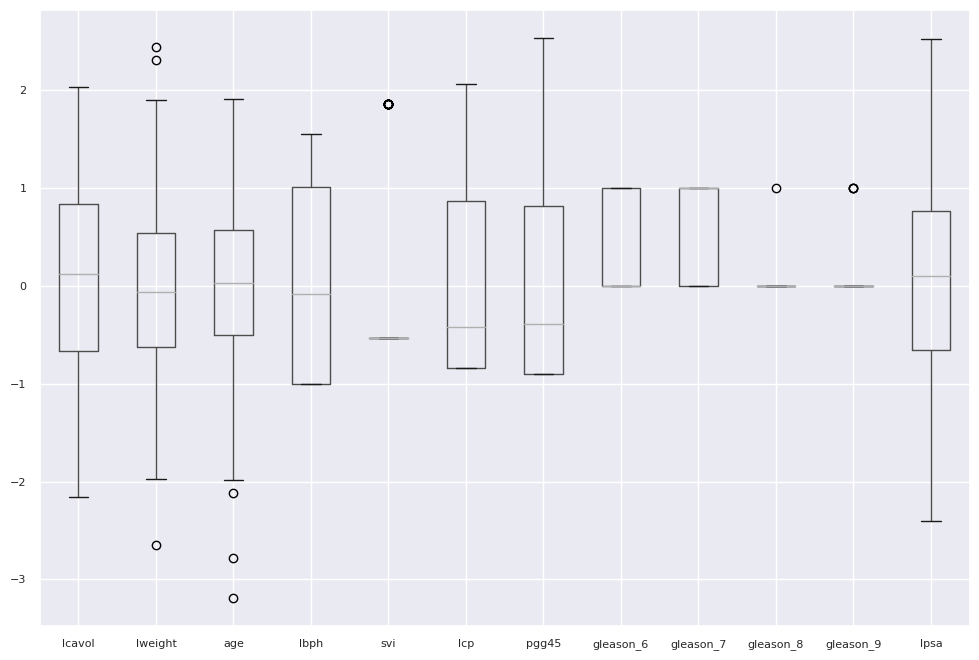

In [111]:
f = data.boxplot(figsize=(12, 8))

# Pre-processing

In [85]:
data = pd.get_dummies(data_raw, prefix=['gleason'], columns=['gleason'], dtype=int)
columns_x = data.columns.tolist()
columns_x.remove("train")
columns_x.remove("lpsa")
columns_y = ['lpsa']
print(columns_x,columns_y)

training_data = data[data['train']=='T'].drop(columns=['train'])
test_data = data[data['train']!='T'].drop(columns=['train'])

print("Training N:", len(training_data), "from NTotal:",len(data))
print("Test N:",len(test_data),"from NTotal:",len(data))

['lcavol', 'lweight', 'age', 'lbph', 'svi', 'lcp', 'pgg45', 'gleason_6', 'gleason_7', 'gleason_8', 'gleason_9'] ['lpsa']
Training N: 67 from NTotal: 97
Test N: 30 from NTotal: 97


In [64]:
print(training_data.head(5))

     lcavol   lweight  age      lbph  svi       lcp  pgg45      lpsa  \
1 -0.579818  2.769459   50 -1.386294    0 -1.386294      0 -0.430783   
2 -0.994252  3.319626   58 -1.386294    0 -1.386294      0 -0.162519   
3 -0.510826  2.691243   74 -1.386294    0 -1.386294     20 -0.162519   
4 -1.203973  3.282789   58 -1.386294    0 -1.386294      0 -0.162519   
5  0.751416  3.432373   62 -1.386294    0 -1.386294      0  0.371564   

   gleason_6  gleason_7  gleason_8  gleason_9  
1          1          0          0          0  
2          1          0          0          0  
3          0          1          0          0  
4          1          0          0          0  
5          1          0          0          0  


In [102]:
from sklearn import preprocessing

cont_predictors = ['lcavol', 'lweight', 'age', 'lbph', 'svi', 'lcp', 'pgg45']
X_train = training_data.loc[:, training_data.columns != 'lpsa']
y_train = np.expand_dims(training_data['lpsa'].values,axis=1)

X_test = test_data.loc[:, test_data.columns != 'lpsa']
y_test = np.expand_dims(test_data['lpsa'].values,axis=1)

## Scaling

In [103]:
x_scaler = preprocessing.StandardScaler().fit(X_train[cont_predictors])
y_scaler = preprocessing.StandardScaler().fit(y_train)

X_train[cont_predictors] = x_scaler.transform(X_train[cont_predictors])
X_test[cont_predictors] = x_scaler.transform(X_test[cont_predictors])

y_train = y_scaler.transform(y_train)
y_test = y_scaler.transform(y_test)